In [1]:
import matplotlib.pyplot as plt
import numpy as np

"""In order to provide a better presentation of the graphs we use the rcParams options shown below."""

import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

In [2]:
import matplotlib.pyplot as plt
from numpy import linalg as LA
import scipy.special

import time
from scipy.integrate import odeint
from scipy.special import zeta
from random import choices

In [3]:
"""Our system of differential equations belongs to the complex space, that is why we implemented the code suggested in"""
"""https://stackoverflow.com/questions/19910189/scipy-odeint-with-complex-initial-values."""

import time
import numpy as np
from scipy.integrate import odeint
from scipy.special import zeta
from random import choices

def odeintz(func, z0, t, **kwargs):
   
    
    """An odeint-like function for complex valued differential equations.

    Inputs:
    ----------
      -func: function associated to dr/dt=f(x;t), where x is the set of parameters and variables to be determined
      -z0: 1d array with length N*(5N-1)/2
      -t: 1d array from t=0 to t=tf (parameter set by the user)
      - **kwargs: keyword arguments related with external functions to be used in odeint
    
    Return:
      -z: multivariable array with the solution of the differential equation associated with each variable"""

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    result = odeint(realfunc, z0.view(np.float64), t, **kwargs)

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict
    else:
        z = result.view(np.complex128)
        return z

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import random, zeros

from numba import jit

dt = 0.0005 # Time step.
T = 10 # Total time.
n = int(T / dt) # Number of time steps.

times = np.linspace(0., T, n)


J=1
N=10
    
refg     = 1
refomega = 1
refdelta=  0

    
Omega =refomega*J
g_coef=refg*J
Delta=refdelta*J
    

Gamma_du=0  #Fixed


Stochastic=1   #Is the process stochastic?
sqrt_N=np.sqrt(N)


theta=np.pi   #Initial state
phi=0



#set the initial values due to the measurements in the state |\psi>=cos(\theta/2)|0>+sin(\theta/2)|1>

from scipy import stats
mk = np.array([-1,1])


xp= (0.5*(1-np.sin(theta)*np.cos(phi)),0.5*(1+np.sin(theta)*np.cos(phi)))
yp= (0.5*(1-np.sin(theta)*np.sin(phi)),0.5*(1+np.sin(theta)*np.sin(phi)))
zp = ((np.cos(theta/2))**2, (np.sin(theta/2))**2)


#xp=(0.5,0.5)
#yp=(0.5,0.5)
#zp=(1,0)



custmx = stats.rv_discrete(name='custmx', values=(mk, xp))
custmy = stats.rv_discrete(name='custmy', values=(mk, yp))
custmz = stats.rv_discrete(name='custmz', values=(mk, zp))




@jit

def trayectory(N=N):
    sqrtdt = np.sqrt(dt)*Stochastic
    
    Results =zeros((3*N+2, n))
    
    
    mu, sigma = 0, 0.5 # mean and standard deviation
    
    Results[3*N][0]=float(np.random.normal(0, 0.5, 1))
    Results[3*N+1][0]=float(np.random.normal(0, 0.5, 1))
    
    for j in range(N):
        
        a=custmx.rvs()
        b=custmy.rvs()
        c=custmz.rvs()
        
        Results[j][0]    =a  
        Results[j+N][0]  =b
        Results[j+2*N][0]=c
        
    
    for t in range(n-1):
        
        Results[3*N][t+1]   = Results[3*N][t]  +dt*Delta*Results[3*N+1][t]    #Initialize the value
        Results[3*N+1][t+1] = Results[3*N+1][t]-dt*Delta* Results[3*N][t]
        
        
        for i in range(N): 
            
            Results[i][t+1]    = Results[i][t]+dt*(-2*g_coef/sqrt_N)*Results[3*N+1][t]*Results[i+2*N][t]
            
            Results[i+N][t+1]  = Results[i+N][t]+dt*(-2*g_coef/sqrt_N)*Results[3*N][t]*Results[i+2*N][t]-dt*Omega*Results[i+2*N][t]  
            
            Results[i+2*N][t+1]= Results[i+2*N][t]+dt*(2*g_coef/sqrt_N)*Results[3*N][t]*Results[i+N][t]+\
                dt*(2*g_coef/sqrt_N)*Results[3*N+1][t]*Results[i][t]+dt*Omega*Results[i+N][t]
            
            Results[3*N][t+1]   += -(g_coef/(2*sqrt_N))*Results[i+N][t]*dt
            Results[3*N+1][t+1] += -(g_coef/(2*sqrt_N))*Results[i][t]*dt
            
    return Results


In [5]:
from numpy import mean
from numpy import linalg

from numba import jit
@jit

def summary_stat(Res,N=N,n=n):
    Results =zeros((10, n))
    count=0
    while count<n:
        a,b,c=Res[0:N, count:count+1],Res[N:2*N, count:count+1],Res[2*N:3*N, count:count+1]
        
        Results[0][count],Results[1][count],Results[2][count]=N*mean(a)/2,N*mean(b)/2,N*mean(c)/2
        Results[3][count]=0.25*(  (N*mean(a))**2- (linalg.norm(a,2))**2 )
        Results[4][count]=0.25*(  (N*mean(b))**2- (linalg.norm(b,2))**2 )
        Results[5][count]=0.25*(  (N*mean(c))**2- (linalg.norm(c,2))**2 )
        Results[6][count]=(N*mean(a)/2)**2
        Results[7][count]=(N*mean(b)/2)**2
        Results[8][count]=(N*mean(c)/2)**2
        
        alpha_x=mean(Res[3*N:3*N+1, count:count+1])
        alpha_y=mean(Res[3*N+1:3*N+2, count:count+1])
        
        Results[9][count]=alpha_x**2+alpha_y**2  #np.power(alpha_x,2)+np.power(alpha_y,2)-0.5
        
        
        count=count+1
        
    
    return Results
    
    

In [6]:
from numpy import add
from numba import jit



itera=5000
@jit

def averages(itera=itera,N=N,n=n,Stochastic=Stochastic):
    Results =zeros((10, n))
    for j in range(itera):
        Trayec=trayectory(N=N)
        Results=add(Results,summary_stat(Trayec,N,n))
    
    return Results/itera
    
    
    
    

In [7]:
t0=time.time()

itera=1000

Result_varDDTWA_EM=averages(itera=itera,N=N,n=n,Stochastic=1)
#Result_varDTWA=averages(itera=itera,N=N,n=n,Stochastic=0)

t1=time.time()

print(t1-t0)



<ipython-input-6-1ec3dfa15f02>:7: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "averages" failed type inference due to: Invalid use of type(CPUDispatcher(<function trayectory at 0x000001A9B1574EE0>)) with parameters (N=int64)

During: resolving callee type: type(CPUDispatcher(<function trayectory at 0x000001A9B1574EE0>))
During: typing of call at <ipython-input-6-1ec3dfa15f02> (12)


File "<ipython-input-6-1ec3dfa15f02>", line 12:
def averages(itera=itera,N=N,n=n,Stochastic=Stochastic):
    <source elided>
    for j in range(itera):
        Trayec=trayectory(N=N)
        ^

  @jit
<ipython-input-6-1ec3dfa15f02>:7: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "averages" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-6-1ec3dfa15f02>", line 11:
def averages(itera=itera,N=N,n=n,Stochastic=Stochastic):

262.7118248939514


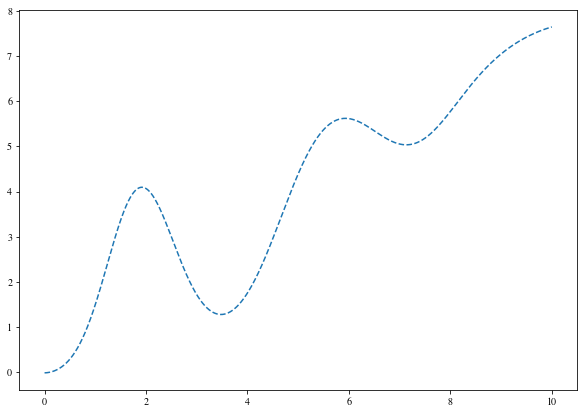

In [8]:
matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)

plt.plot(times, Result_varDDTWA_EM[-1]-0.5,"--",label="Sx DDTWA EM")

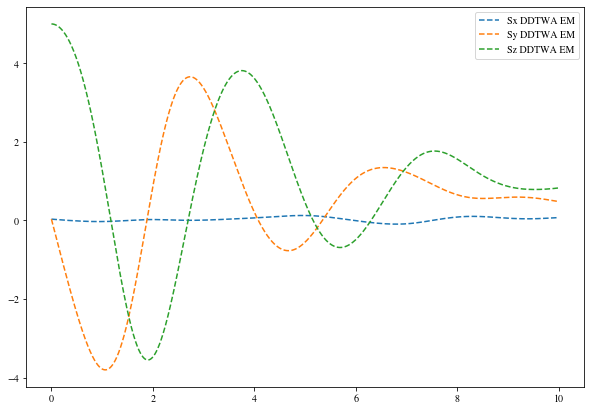

In [9]:

matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)

plt.plot(times, Result_varDDTWA_EM[0],"--",label="Sx DDTWA EM")

plt.plot(times, Result_varDDTWA_EM[1],"--",label="Sy DDTWA EM")

plt.plot(times, Result_varDDTWA_EM[2],"--",label="Sz DDTWA EM")


plt.legend()

In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import numpy as np


from qutip import *
from qutip.piqs import *

import matplotlib.animation as animation
from IPython.display import HTML
from IPython.core.display import Image, display

In [11]:
Delta

0

In [12]:
# TLS parameters
n_tls = N
system = Dicke(N = n_tls)
[jx, jy, jz] = jspin(N)
jp = jspin(N,"+")
jm = jp.dag()

system.hamiltonian = Omega * jx
system.dephasing = 0
D_tls = system.liouvillian() 



# Light-matter coupling parameters

kappa = 0

nphot = int(2*N+2)  #modes of light
a = destroy(nphot)
h_int = (g_coef/np.sqrt(N)) *(tensor(a, jp)+tensor(a.dag(), jm))



# Photonic Liouvillian
c_ops_phot = [np.sqrt(kappa) * a]

D_phot = liouvillian(Delta * a.dag()*a , c_ops_phot)

# Identity super-operators
nds = num_dicke_states(n_tls)
id_tls = to_super(qeye(nds))
id_phot = to_super(qeye(nphot))

# Define the total Liouvillian
D_int = -1j* spre(h_int) + 1j* spost(h_int)
D_tot = D_int + super_tensor(D_phot, id_tls) + super_tensor(id_phot, D_tls)

# Define operator in the total space
nphot_tot = tensor(a.dag()*a, qeye(nds))
jx_tot=tensor(qeye(nphot), jx)
jy_tot=tensor(qeye(nphot), jy)
jz_tot=tensor(qeye(nphot), jz)



In [13]:
ground_state = dicke(N, N/2, -N/2)

In [14]:
excited_state = excited(N)
ground_state = dicke(N, N/2, -N/2)

ground_phot = ket2dm(basis(nphot,0))  #vacuum
rho0 = tensor(ground_phot, excited_state)
#rho0 = tensor(ground_phot, ground_state)



t = np.linspace(0, 10, 1000)
result1 = mesolve(D_tot, rho0, t, [], e_ops = [nphot_tot], 
                  options = Options(store_states=True))    #[nphot_tot,jx,jy,jz]

nphot_t = result1.expect[0]

In [15]:
excited_state = excited(N)
ground_state = dicke(N, N/2, -N/2)

ground_phot = ket2dm(basis(nphot,0))  #vacuum
rho0 = tensor(ground_phot, excited_state)
#rho0 = tensor(ground_phot, ground_state)



t = np.linspace(0, 10, 1000)
result2 = mesolve(D_tot, rho0, t, [], e_ops = [nphot_tot,jx_tot,jy_tot,jz_tot], 
                  options = Options(store_states=True))    #[nphot_tot,jx,jy,jz]
rhot_tot = result2.states
nphot_t = result2.expect[0]
jx_t = result2.expect[1]
jy_t = result2.expect[2]
jz_t = result2.expect[3]

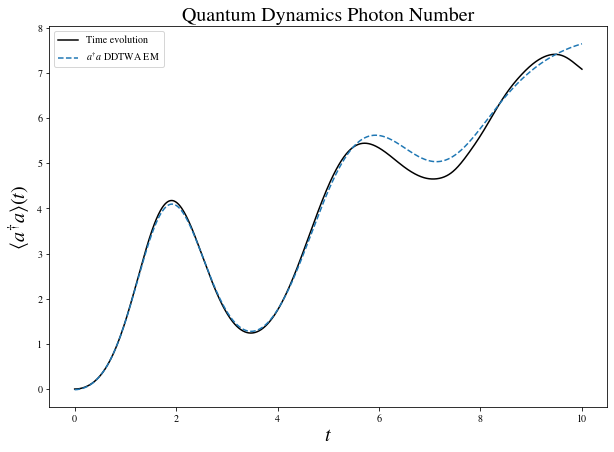

In [19]:
j_max = N/2.
label_size = 20


fig3 = plt.figure(3)
plt.plot(t, nphot_t, 'k-', label='Time evolution')
plt.title(r'Quantum Dynamics Photon Number', fontsize = label_size)
plt.xlabel(r'$t$', fontsize = label_size)
#plt.ylabel(r'$\langle a^\dagger a\rangle(t)$', fontsize = label_size)
plt.ylabel(r'$\langle a^{\dagger}a \rangle(t)$', fontsize = label_size)


plt.plot(times, Result_varDDTWA_EM[-1]-0.5,"--",label="$a^{\dagger}a$ DDTWA EM")




#plt.legend(fontsize = label_size)
plt.legend()
plt.show()
plt.close()

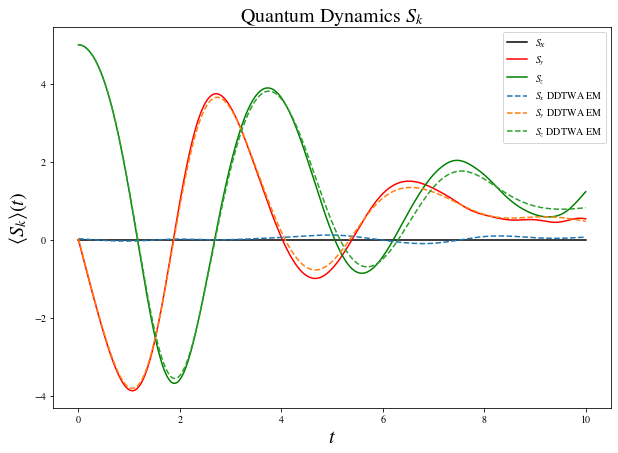

In [27]:
j_max = N/2.
label_size = 20


fig3 = plt.figure(3)

plt.plot(t, jx_t, 'k-', label='$S_X$')
plt.plot(t, jy_t, 'r-', label='$S_y$')
plt.plot(t, jz_t, 'g-', label='$S_z$')

plt.title(r'Quantum Dynamics $S_k$', fontsize = label_size)
plt.xlabel(r'$t$', fontsize = label_size)
#plt.ylabel(r'$\langle a^\dagger a\rangle(t)$', fontsize = label_size)
plt.ylabel(r'$\langle S_k \rangle(t)$', fontsize = label_size)


plt.plot(times, Result_varDDTWA_EM[0],"--",label="$S_x$ DDTWA EM")

plt.plot(times, Result_varDDTWA_EM[1],"--",label="$S_y$ DDTWA EM")

plt.plot(times, Result_varDDTWA_EM[2],"--",label="$S_z$ DDTWA EM")




#plt.legend(fontsize = label_size)
plt.legend()
plt.show()
plt.close()

In [ ]:
n_tls

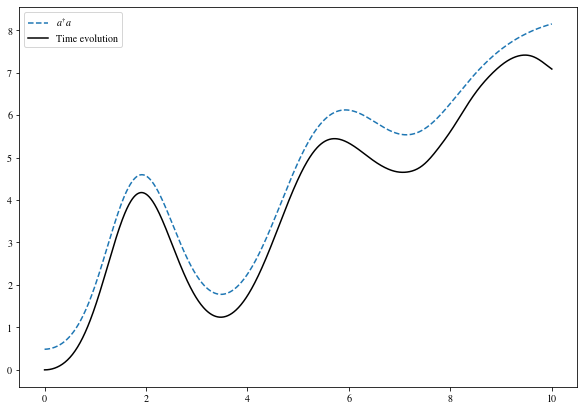

In [17]:
plt.plot(times, Result_varDDTWA_EM[-1],"--",label="$a^{\dagger}a$")
plt.plot(t, nphot_t, 'k-', label='Time evolution')

plt.legend()

In [ ]:

from numba import jit

#@jit


#@jit

def Aplus_j(n):
    if 0<=n<=N:
        return np.sqrt( (N-n)*  (n+1) )
    else:
        return 0
#@jit
    
def Aminus_j(n):
    if 0<=n<=N:
        return np.sqrt( (n)*  (N-n+1) )
    else:
        return 0    
    
#@jit    
def Az(n):
    return -N/2+n

In [ ]:
N

In [ ]:
L=20

def index_list(N=N,L=L):
    Index_list=[]
    for j in range(N+1):
        for k in range(L+1):
            Index_list.append([j,k])
    return Index_list

In [ ]:
Index_list=index_list(N,L)

Index_list.count([4,6])

In [ ]:
def Aplus_j(n):
    if 0<=n<=N:
        return np.sqrt( (N-n)*  (n+1) )
    else:
        return 0

    
def Aminus_j(n):
    if 0<=n<=N:
        return np.sqrt( (n)*  (N-n+1) )
    else:
        return 0    
    
    
def Az(n):
    return -N/2+n


from numba import jit

#@jit



def vectorsR(r, t,J=J,N=N,Omega=Omega,g_coef=g_coef):#,Vect=Vect):   
            
    #matrix_zero=np.zeros((int(3*N),int(3*N)),dtype = 'complex_')
    matrix_zero=np.zeros((int( (N+1)*(L+1)),int((N+1)*(L+1))), dtype = 'complex_')
    
    drdt =  np.matmul(matrix_zero, r)  #matrix_zero @ r   #sum of the linear and the constant part
    #drdt = matrix_zero @ r
    
    Index_list=index_list(N,L)
    
    
    
    ###Define Vect which is an array of coordinates of size N
    
    count=0
       
    
    for vect in Index_list:
        n1  =vect[0]
        npr1=vect[1]
        npr=npr1

        
        cfinnpr=Index_list.count([n1,npr1])
        indnnpr=Index_list.index(list(cfinnpr*np.array([n1,npr1])))   
        
        cfinm1nprp1=Index_list.count([n1-1,npr1+1])
        indnm1nprp1=Index_list.index(list(cfinm1nprp1*np.array([n1-1,npr1+1]))) 
        
        cfinp1nprm1=Index_list.count([n1+1,npr1-1])
        indnp1nprm1=Index_list.index(list(cfinp1nprm1*np.array([n1+1,npr1-1]))) 

        cfinm1npr=Index_list.count([n1-1,npr1])
        indnm1npr=Index_list.index(list(cfinm1npr*np.array([n1-1,npr1])))
        
        cfinp1npr=Index_list.count([n1+1,npr1])
        indnp1npr=Index_list.index(list(cfinp1npr*np.array([n1+1,npr1])))
      
        
            
        drdt[indnnpr]+= -1j*(g_coef/np.sqrt(N))* Aplus_j(n1-1)*np.sqrt(npr1+1)*cfinm1nprp1*r[indnm1nprp1]+\
            -1j*(g_coef/np.sqrt(N))* Aminus_j(n1+1)*np.sqrt(npr1)*cfinp1nprm1*r[indnp1nprm1]+\
            -1j*(Delta*npr1*cfinnpr*r[indnnpr])+\
            -1j*(Omega/2)*Aplus_j(n1-1)*cfinm1npr*r[indnm1npr]-1j*(Omega/2)*Aminus_j(n1+1)*cfinp1npr*r[indnp1npr]
        
        
               
    return drdt




r0=int((N+1)*(L+1))*[0]

r0[0]=1

rinit=r0

In [ ]:
#T=10
#n=8000


times1 = times #np.linspace(0., T, n)

In [ ]:
t0=time.time()

z=odeintz(vectorsR, list(r0), times1)#, args=(N,L))
t1=time.time()

In [ ]:
for j in range((N+1)*(L+1)):
    plt.plot(times,np.real(z[:,j]))
    plt.plot(times,np.imag(z[:,j]))

print(t1-t0,N,L)

In [ ]:

@jit
def adag_a(index):
    Psi_state=z[index,:]
    Index_list=index_list(N,L)
    
    count=0
    
    adag_a=0
    adag_a_cuad=0
    sz=0
    

    for vect in Index_list:
        
        n_mat =vect[0]
        l_lig =vect[1]
        c_cuad=(LA.norm(z[index,:][count]))**2
        
        adag_a=adag_a+l_lig*c_cuad
        adag_a_cuad=adag_a_cuad+l_lig*(l_lig-1)*c_cuad
        sz = sz+Az(n_mat)*c_cuad
    
        count=count+1
        
    return adag_a, adag_a_cuad, sz
    

In [ ]:
Adag_a_list=[]
Adag_a_cuad_list=[]

sz_value=[]

corr_g=[]




for j in range(len(times)):
    #Adag_a_list.append(adag_a(j)[0])
    #Adag_a_cuad_list.append(adag_a(j)[1])
    
    sz_value.append(adag_a(j)[2])
    
    #corr_g.append(adag_a(j)[1]/(adag_a(j)[0])**2)
    
    

#for j in range(len(t)):
    
    

In [ ]:
#plt.plot(t,Adag_a_cuad_list)
#plt.plot(t,Adag_a_list)

matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)

plt.plot(times,-np.array(sz_value),label="Sz SE")

plt.plot(times, Result_varDDTWA_EM[2],"-",label="Sz DDTWA EM")

plt.plot(t, jz_t, 'k-', label='Time evolution')


plt.legend()

#plt.plot(times, Result_varDDTWA_EM[2],"-",label="Sz DDTWA EM")

In [ ]:

from numba import jit

#@jit


#@jit

def Aplus_j(n):
    if 0<=n<=N:
        return np.sqrt( (N-n)*  (n+1) )
    else:
        return 0
#@jit
    
def Aminus_j(n):
    if 0<=n<=N:
        return np.sqrt( (n)*  (N-n+1) )
    else:
        return 0    
    
#@jit    
def Az(n):
    return -N/2+n

In [ ]:
chi

In [ ]:
# Dicke Basis "exact" solution master equation

In [ ]:
def index_list(N=N):
    Index_list=[]
    for j in range(N+1):
        for k in range(N+1):
            Index_list.append([j,k])
    return Index_list
    

In [ ]:
def Aplus_j(n):
    if 0<=n<=N:
        return np.sqrt( (N-n)*  (n+1) )
    else:
        return 0

    
def Aminus_j(n):
    if 0<=n<=N:
        return np.sqrt( (n)*  (N-n+1) )
    else:
        return 0    
    
    
def Az(n):
    return -N/2+n



Gamma_phi=refgamma*J
Gamma_C=Gamma_decay

Omega=refomega*J

from numba import jit

#@jit



def vectorsR(r, t,J=J,N=N,Omega=Omega,Gamma_C=Gamma_C,Gamma_phi=Gamma_phi):#,Vect=Vect):   
            
    #matrix_zero=np.zeros((int(3*N),int(3*N)),dtype = 'complex_')
    matrix_zero=np.zeros((int( (N+1)**2  ),int((N+1)**2)),dtype = 'complex_')
    
    drdt =  np.matmul(matrix_zero, r)  #matrix_zero @ r   #sum of the linear and the constant part
    #drdt = matrix_zero @ r
    
    Index_list=index_list(N)
    
    
    
    
    
    ###Define Vect which is an array of coordinates of size N
    
    count=0
       
    
    for vect in Index_list:
        n1  =vect[0]
        npr1=vect[1]
        npr=npr1

        
        cfinnpr=Index_list.count([n1,npr1])
        indnnpr=Index_list.index(list(cfinnpr*np.array([n1,npr1])))       
        
        cfinnprm1=Index_list.count([n1,npr1-1])
        indnnprm1=Index_list.index(list(cfinnprm1*np.array([n1,npr1-1])))
        
        cfinp1npr=Index_list.count([n1+1,npr1])
        indnp1npr=Index_list.index(list(cfinp1npr*np.array([n1+1,npr1])))        
        
        cfinnprp1=Index_list.count([n1,npr1+1])
        indnnprp1=Index_list.index(list(cfinnprp1*np.array([n1,npr1+1])))
        
        cfinm1npr=Index_list.count([n1-1,npr1])
        indnm1npr=Index_list.index(list(cfinm1npr*np.array([n1-1,npr1])))    
            
        cfinp1nprp1=Index_list.count([n1+1,npr1+1])
        indnp1nprp1=Index_list.index(list(cfinp1nprp1*np.array([n1+1,npr1+1])))
            

        
        
            
        drdt[indnnpr]+=1j*(Omega/2)* Aplus_j(npr1-1)*cfinnprm1*r[indnnprm1]+\
            -1j*(Omega/2)*Aplus_j(n1-1)*cfinm1npr*r[indnm1npr]+1j*(Omega/2)*Aminus_j(npr1+1)*cfinnprp1*r[indnnprp1]+\
            -1j*(Omega/2)*Aminus_j(n1+1)*cfinp1npr*r[indnp1npr]+Gamma_C*Aminus_j(n1+1)*Aminus_j(npr+1)*cfinp1nprp1*r[indnp1nprp1]+\
            1j*(chi/N)*( Aplus_j(npr1-1)*Aminus_j(npr1)-Aplus_j(n1-1)*Aminus_j(n1)   )*cfinnpr*r[indnnpr]+\
            -(Gamma_C/2)*(Aminus_j(n1)*Aplus_j(n1-1) + Aminus_j(npr1)*Aplus_j(npr1-1) )*cfinnpr*r[indnnpr]

               
    return drdt




r0=int((N+1)**2)*[0]

r0[0]=1

rinit=r0

In [ ]:
#T=40
#n=2000


#times = np.linspace(0., T, n)

In [ ]:
type(r0)

In [ ]:
t0=time.time()

z=odeintz(vectorsR, list(r0), times)#, args=(N,L))
t1=time.time()

In [ ]:
for j in range((N+1)**2):
    plt.plot(times,np.real(z[:,j]))
    plt.plot(times,np.imag(z[:,j]))

print(t1-t0,N)

In [ ]:
#z[3,:]  We obtain the third elements of the density matrix

"We can determine the density matrix using the following function"

from numba import jit

#@jit

def rho_matr(time_index):
    rho_matr=np.zeros((int( (N+1)  ),int((N+1))),dtype = 'complex_')
    count=0
    for i in range(N+1):
        for j in range(N+1):
            rho_matr[i][j]= z[time_index,:][count]
            
            count=count+1
            
    return rho_matr

In [ ]:
def Sxyz_dicke(N=N):
    S_x=np.zeros((int( (N+1)  ),int((N+1))),dtype = 'complex_')
    S_y=np.zeros((int( (N+1)  ),int((N+1))),dtype = 'complex_')
    S_z=np.zeros((int( (N+1)  ),int((N+1))),dtype = 'complex_')

    for n in range(1,N+1):
        S_x[n][n-1]= 0.5*Aplus_j(n-1)
        S_y[n][n-1]=(-0.5*1j)*Aplus_j(n-1)
    
    for n in range(0,N):
        S_x[n][n+1]= 0.5*Aminus_j(n+1)
        S_y[n][n+1]=(0.5*1j)*Aminus_j(n+1)  
        S_z[n][n]=-N/2+n
    S_z[N][N]=N/2
    return S_x, S_y, S_z

In [ ]:

t=times

Sx=Sxyz_dicke(N)[0]
Sy=Sxyz_dicke(N)[1]
Sz=Sxyz_dicke(N)[2]


Sx_result_ME=[]
Sy_result_ME=[]
Sz_result_ME=[]

for j in range(len(t)):
    Refmat=rho_matr(j)
    Sx_result_ME.append(np.trace(np.matmul(Sx, Refmat )))
    Sy_result_ME.append(np.trace(np.matmul(Sy, Refmat )))
    Sz_result_ME.append(np.trace(np.matmul(Sz, Refmat )))
    

In [ ]:

matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)

plt.plot(times, Result_varDDTWA_EM[0],"--",label="Sx DDTWA EM")

plt.plot(times, Result_varDDTWA_EM[1],"--",label="Sy DDTWA EM")

plt.plot(times, Result_varDDTWA_EM[2],"--",label="Sz DDTWA EM")


plt.plot(times,np.real(Sx_result_ME),label="Sx")    #Master equation
plt.plot(times,np.real(Sy_result_ME),label="Sy")    #Master equation
plt.plot(times,np.real(Sz_result_ME),label="Sz")    #Master equation


plt.legend()

In [ ]:
#Comparison between DDTWA and master equation

In [ ]:

t=times

Sx=Sxyz_dicke(N)[0]
Sy=Sxyz_dicke(N)[1]
Sz=Sxyz_dicke(N)[2]
Sx_cuad=np.matmul(Sx,Sx)
Sy_cuad=np.matmul(Sy,Sy)
Sz_cuad=np.matmul(Sz,Sz)




Sx_result=[]
Sy_result=[]
Sz_result=[]
Sx_cuad_result=[]
Sy_cuad_result=[]
Sz_cuad_result=[]


for j in range(len(t)):
    Refmat=rho_matr(j)

    
    
    
    Sx_result.append(np.trace(np.matmul(Sx, Refmat )))
    Sy_result.append(np.trace(np.matmul(Sy, Refmat )))
    Sz_result.append(np.trace(np.matmul(Sz, Refmat )))
    Sx_cuad_result.append(np.trace(np.matmul(Sx_cuad, Refmat )))
    Sy_cuad_result.append(np.trace(np.matmul(Sy_cuad, Refmat )))
    Sz_cuad_result.append(np.trace(np.matmul(Sz_cuad, Refmat )))

In [ ]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

plt.title("$(\Delta S_k)^2$ Evolution under full(factorization) algebra")



matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

ax_EM=N/4+  Result_varDDTWA_EM[3+0]-(Result_varDDTWA_EM[0])**2
ay_EM=N/4+  Result_varDDTWA_EM[3+1]-(Result_varDDTWA_EM[1])**2
az_EM=N/4+  Result_varDDTWA_EM[3+2]-(Result_varDDTWA_EM[2])**2

ax1_EM=np.array(Result_varDDTWA_EM[6+0])-np.array((Result_varDDTWA_EM[0])**2)
ay1_EM=np.array(Result_varDDTWA_EM[6+1])-np.array((Result_varDDTWA_EM[1])**2)
az1_EM=np.array(Result_varDDTWA_EM[6+2])-np.array((Result_varDDTWA_EM[2])**2)


#plt.plot(times,ax1_EM,"-.",label="DDTWA $(\Delta S_x)^2 $ EM no-algebra")
#plt.plot(times,ay1_EM,"-.",label="DDTWA $(\Delta S_y)^2 $ EM no-algebra")
#plt.plot(times,az1_EM,"-.",label="DDTWA $(\Delta S_z)^2 $ EM no-algebra")


plt.plot(times,ax_EM,"--",label="DDTWA $(\Delta S_x)^2$ EM full-algebra")
plt.plot(times,ay_EM,"--",label="DDTWA $(\Delta S_y)^2$ EM full-algebra")
plt.plot(times,az_EM,"--",label="DDTWA $(\Delta S_z)^2$ EM full-algebra")





#ax_SH=N/4+  Result_varDDTWA_SH[3+0]-(Result_varDDTWA_SH[0])**2
#ay_SH=N/4+  Result_varDDTWA_SH[3+1]-(Result_varDDTWA_SH[1])**2
#az_SH=N/4+  Result_varDDTWA_SH[3+2]-(Result_varDDTWA_SH[2])**2

#ax1_SH=np.array(Result_varDDTWA_SH[6+0])-np.array((Result_varDDTWA_SH[0])**2)
#ay1_SH=np.array(Result_varDDTWA_SH[6+1])-np.array((Result_varDDTWA_SH[1])**2)
#az1_SH=np.array(Result_varDDTWA_SH[6+2])-np.array((Result_varDDTWA_SH[2])**2)


#plt.plot(times,ax1_SH,"-.",label="DDTWA $(\Delta S_x)^2 $ SH no-algebra")
#plt.plot(times,ay1_SH,"-.",label="DDTWA $(\Delta S_y)^2 $ SH no-algebra")
#plt.plot(times,az1_SH,"-.",label="DDTWA $(\Delta S_z)^2 $ SH no-algebra")


#plt.plot(times,ax_SH,"--",label="DDTWA $(\Delta S_x)^2$ SH full-algebra")
#plt.plot(times,ay_SH,"--",label="DDTWA $(\Delta S_y)^2$ SH full-algebra")
#plt.plot(times,az_SH,"--",label="DDTWA $(\Delta S_z)^2$ SH full-algebra")





Dicke_xx=np.real(np.array(Sx_cuad_result))-(np.real(Sx_result))**2
Dicke_yy=np.real(np.array(Sy_cuad_result))-(np.real(Sy_result))**2
Dicke_zz=np.real(np.array(Sz_cuad_result))-(np.real(Sz_result))**2


plt.plot(times,Dicke_xx,"-",label="Dicke Var(S_x)")
plt.plot(times,Dicke_yy,"-",label="Dicke Var(S_y)")
plt.plot(times,Dicke_zz,"-",label="Dicke Var(S_z)")



plt.legend()

In [ ]:
J

In [ ]:
# Dicke basis "exact" solution Schrodinger equation

In [ ]:
def vectorsR(r, t,J=J,N=N,Omega=Omega):#,Vect=Vect):   
            
    #matrix_zero=np.zeros((int(3*N),int(3*N)),dtype = 'complex_')
    matrix_zero=np.zeros((int( (N+1)  ),int((N+1))),dtype = 'complex_')
    
    
    drdt =  np.matmul(matrix_zero, r)  #matrix_zero @ r   #sum of the linear and the constant part
    #drdt = matrix_zero @ r
    
    
    
    ###Define Vect which is an array of coordinates of size N
    
       
    drdt[0]=-1j*( (Omega/2)*r[1]*Aminus_j(1) )
    drdt[N]=-1j*( (Omega/2)*r[N-1]*Aplus_j(N-1)+(chi/N)*r[N]*Aplus_j(N-1)*Aminus_j(N) )
    
    
    for m in range(1,N):
        drdt[m]+=(-1j)*( (Omega/2)*( r[m-1]*Aplus_j(m-1)+r[m+1]*Aminus_j(m+1) )+(chi/N)*Aplus_j(m-1)*Aminus_j(m)*r[m]  )
        
       
    return drdt



In [ ]:
def dicke_list(N=N):
    State_list=[]
    State_list.append(  (np.cos(theta/2))**N  )
    
    for n in range(1,N):
        Coef=((scipy.special.binom(N, n))**0.5)*( (np.cos(theta/2))**(N-n) )*( (np.sin(theta/2))**(n) )*np.exp(1j*n*phi)
        State_list.append(Coef)
    
    State_list.append( ( (np.sin(theta/2))**N)*np.exp(1j*N*phi)   )
    
    return State_list
    

D_list=dicke_list(N=N)

r0=D_list

#r0=list(r0[::-1])

In [ ]:
t0=time.time()

z=odeintz(vectorsR, r0, times)#, args=(N,L))
t1=time.time()

In [ ]:
for j in range((N+1)):
    plt.plot(times,np.real(z[:,j]))
    plt.plot(times,np.imag(z[:,j]))

print(t1-t0,N)

In [ ]:
#z[3,:]  We obtain the third elements of the density matrix

"We can determine the density matrix using the following function"

from numba import jit

#@jit

def state_vector(time_index):
    state_vect=np.zeros((int( (N+1)  )),dtype = 'complex_')
    count=0
    for i in range(N+1):
            state_vect[i]= z[time_index,:][i]
            
    return state_vect

In [ ]:
def Sxyz_dicke(N=N):
    S_x=np.zeros((int( (N+1)  ),int((N+1))),dtype = 'complex_')
    S_y=np.zeros((int( (N+1)  ),int((N+1))),dtype = 'complex_')
    S_z=np.zeros((int( (N+1)  ),int((N+1))),dtype = 'complex_')

    for n in range(1,N+1):
        S_x[n][n-1]= 0.5*Aplus_j(n-1)
        S_y[n][n-1]=(-0.5*1j)*Aplus_j(n-1)
    
    for n in range(0,N):
        S_x[n][n+1]= 0.5*Aminus_j(n+1)
        S_y[n][n+1]=(0.5*1j)*Aminus_j(n+1)  
        S_z[n][n]=-N/2+n
    S_z[N][N]=N/2
    return S_x, S_y, S_z, matmul(S_x,S_x),matmul(S_y,S_y),matmul(S_z,S_z)

In [ ]:
from numpy import matmul, conjugate, transpose

ti=times

Sx=Sxyz_dicke(N)[0]
Sy=Sxyz_dicke(N)[1]
Sz=Sxyz_dicke(N)[2]
Sxx=Sxyz_dicke(N)[3]
Syy=Sxyz_dicke(N)[4]
Szz=Sxyz_dicke(N)[5]

Sx_result=[]
Sy_result=[]
Sz_result=[]
Sxx_result=[]
Syy_result=[]
Szz_result=[]


In [ ]:
def conjtrans(A):
    return conjugate(transpose(A))

In [ ]:
for j in range(len(ti)):
    
    st_vect=state_vector(j)
    st_trans=conjtrans(st_vect)
    
    
    Sx_result.append(np.dot(st_trans,(matmul(st_vect,Sx ))))
    Sy_result.append(np.dot(st_trans,(matmul(st_vect,Sy ))))
    Sz_result.append(np.dot(st_trans,(matmul(st_vect,Sz ))))
    Sxx_result.append(np.dot(st_trans,(matmul(st_vect,Sxx ))))
    Syy_result.append(np.dot(st_trans,(matmul(st_vect,Syy ))))
    Szz_result.append(np.dot(st_trans,(matmul(st_vect,Szz ))))
    
    
    

In [ ]:
matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)
matplotlib.rcParams['font.size'] = 15
plt.title("Evolution of $<S_k>$ Under Local Noise")

plt.plot(times, Result_varDDTWA_EM[0],"--",label="Sx DDTWA EM")
#plt.plot(times, Result_varDDTWA_SH[0],"--",label="Sx DDTWA SH")

plt.plot(times, Result_varDDTWA_EM[1],"--",label="Sy DDTWA EM")
#plt.plot(times, Result_varDDTWA_SH[1],"--",label="Sy DDTWA SH")

plt.plot(times, Result_varDDTWA_EM[2],"--",label="Sz DDTWA EM")
#plt.plot(times, Result_varDDTWA_SH[2],"--",label="Sz DDTWA SH")


plt.plot(times,np.real(np.array(Sx_result)),label="x")
plt.plot(times,np.real(-np.array(Sy_result)),label="y")
plt.plot(times,np.real(np.array(Sz_result)),label="z")



#plt.plot(times,np.real(Sx_result_ME),"-.",label="Sx ME")    #Master equation
#plt.plot(times,np.real(Sy_result_ME),"-.",label="Sy ME")    #Master equation
#plt.plot(times,np.real(Sz_result_ME),"-.",label="Sz ME")    #Master equation


plt.legend()

In [ ]:
N

In [ ]:



matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)

axEM=N/4+  Result_varDDTWA_EM[3+0]-(Result_varDDTWA_EM[0])**2
ayEM=N/4+  Result_varDDTWA_EM[3+1]-(Result_varDDTWA_EM[1])**2
azEM=N/4+  Result_varDDTWA_EM[3+2]-(Result_varDDTWA_EM[2])**2


ax1EM=np.array(Result_varDDTWA_EM[6+0])-np.array((Result_varDDTWA_EM[0])**2)
ay1EM=np.array(Result_varDDTWA_EM[6+1])-np.array((Result_varDDTWA_EM[1])**2)
az1EM=np.array(Result_varDDTWA_EM[6+2])-np.array((Result_varDDTWA_EM[2])**2)



#axSH=N/4+  Result_varDDTWA_SH[3+0]-(Result_varDDTWA_SH[0])**2
#aySH=N/4+  Result_varDDTWA_SH[3+1]-(Result_varDDTWA_SH[1])**2
#azSH=N/4+  Result_varDDTWA_SH[3+2]-(Result_varDDTWA_SH[2])**2


#ax1SH=np.array(Result_varDDTWA_SH[6+0])-np.array((Result_varDDTWA_SH[0])**2)
#ay1SH=np.array(Result_varDDTWA_SH[6+1])-np.array((Result_varDDTWA_SH[1])**2)
#az1SH=np.array(Result_varDDTWA_SH[6+2])-np.array((Result_varDDTWA_SH[2])**2)



#plt.plot(times,axEM,"--",label="DDTWA $(\Delta S_x)^2$ EM")
#plt.plot(times,ayEM,"--",label="DDTWA $(\Delta S_y)^2$ EM")
#plt.plot(times,azEM,"--",label="DDTWA $(\Delta S_z)^2$ EM")

plt.plot(times,ax1EM,"-.",label="DDTWA $(\Delta S_x)^2 $ no-algebra EM")
plt.plot(times,ay1EM,"-.",label="DDTWA $(\Delta S_y)^2 $ no-algebra EM")
plt.plot(times,az1EM,"-.",label="DDTWA $(\Delta S_z)^2 $ no-algebra EM")


#plt.plot(times,axSH,"--",label="DDTWA $(\Delta S_x)^2$ SH")
#plt.plot(times,aySH,"--",label="DDTWA $(\Delta S_y)^2$ SH")
#plt.plot(times,azSH,"--",label="DDTWA $(\Delta S_z)^2$ SH")

#plt.plot(times,ax1SH,"-.",label="DDTWA $(\Delta S_x)^2 $ no-algebra SH")
#plt.plot(times,ay1SH,"-.",label="DDTWA $(\Delta S_y)^2 $ no-algebra SH")
#plt.plot(times,az1SH,"-.",label="DDTWA $(\Delta S_z)^2 $ no-algebra SH")


plt.plot(times,np.real(np.array(Sxx_result))-(np.array(Sx_result))**2,label="xx")
plt.plot(times,np.real(np.array(Syy_result))-(np.array(Sy_result))**2,label="yy")
plt.plot(times,np.real(np.array(Szz_result))-(np.array(Sz_result))**2,label="zz")

plt.legend()




plt.legend(loc="upper left")

In [ ]:
chi

In [ ]:
## Stratonovich (in preparation yet)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import random, zeros

from numba import jit






@jit

def trayectorystra(N=N,Stochastic=Stochastic):
    sqrtdt = np.sqrt(dt)*Stochastic
    
    Results = zeros((3*N, n))
    Rbar    = zeros((3*N, n))
    RandomNumbers= zeros((n))  #Local noise requires N rows for simulating the noise of each spin
    

    for j in range(N):
        
        
        #a=custmx.rvs()
        #b=custmy.rvs()
        #c=custmz.rvs()
        
        #Results[j][0]=a  
        #Results[j+N][0]=b
        #Results[j+2*N][0]=c
        
    
        a=custmx.rvs()
        b=custmy.rvs()
        c=custmz.rvs()
        
        Results[j][0]=a  
        Results[j+N][0]=b
        Results[j+2*N][0]=c


    for t in range(n-1):
        
        RandomNumbers[t]=random.randn()
        Normal_VA=RandomNumbers[t]
        
        for i1 in range(N):

            
            
            Rbar[i1][t]     = Results[i1][t] -(chi/N)*Results[i1+N][t]*dt   +dt*(-Gamma_phi-(Gamma_decay/2)+gama_sq )*Results[i1][t]-\
                (sqrt_2phi+sqrt_decay ) *Results[i1+N][t]* sqrtdt * Normal_VA
            Rbar[i1+N][t]   = Results[i1+N][t]  +dt*(-Omega*Results[i1+2*N][t] +(-Gamma_phi- (Gamma_decay/2)+gama_sq)*Results[i1+N][t])+\
                (sqrt_2phi+sqrt_decay ) *Results[i1][t]* sqrtdt * Normal_VA+(chi/N)*Results[i1][t]*dt
            Rbar[i1+2*N][t] = Results[i1+2*N][t]+dt*( Omega*Results[i1+N][t] - 1.5*Gamma_decay*(Results[i1+2*N][t]+1) )+\
                sqrt_decay*(Results[i1+2*N][t]+1)*sqrtdt * Normal_VA
            
            for j1 in range(N):
                if i1!=j1:
                    
                    Rbar[i1][t]  +=0+\
                        (Gamma_decay/2)*Results[i1+2*N][t]*Results[j1][t] *dt+(chi/N)*Results[i1+2*N][t]*Results[j1+N][t]*dt
                    Rbar[i1+N][t]+= 0+\
                        (Gamma_decay/2)*Results[i1+2*N][t]*Results[j1+N][t] *dt-(chi/N)*Results[i1+2*N][t]*Results[j1][t]*dt
                    Rbar[i1+2*N][t]+=-(Gamma_decay/2)*(Results[i1][t]*Results[j1][t]+Results[i1+N][t]*Results[j1+N][t]) *dt+\
                        (chi/N)*(Results[i1+N][t]*Results[j1][t] - Results[i1][t]*Results[j1+N][t])
            
#-------------------------------------------------------------------------------------------------------            
        
        for i in range(N): 
            
                        
            fxn   = (-Gamma_phi-(Gamma_decay/2)+gama_sq )*Results[i][t]-(chi/N)*Results[i+N][t]
            Gxn   = -(sqrt_2phi+sqrt_decay )     *Results[i+N][t]
            fxbarn= (-Gamma_phi-(Gamma_decay/2)+gama_sq )*Rbar[i][t]-(chi/N)*Rbar[i+N][t]
            Gxbarn= -(sqrt_2phi+sqrt_decay )     *Rbar[i+N][t]     
            
            fyn   = (-Omega*Results[i+2*N][t] -(Gamma_phi+ (Gamma_decay/2)-gama_sq)*Results[i+N][t])+(chi/N)*Results[i][t]
            Gyn   = (sqrt_2phi+sqrt_decay ) *Results[i][t]
            fybarn= (-Omega*Rbar[i+2*N][t] -(Gamma_phi+ (Gamma_decay/2)-gama_sq)*Rbar[i+N][t])+(chi/N)*Rbar[i][t]
            Gybarn= (sqrt_2phi+sqrt_decay ) *Rbar[i][t]
            
            fzn   = ( Omega*Results[i+N][t] - 1.5*Gamma_decay*(Results[i+2*N][t]+1) )
            Gzn   = sqrt_decay*(Results[i+2*N][t]+1)
            fzbarn= ( Omega*Rbar[i+N][t] - 1.5*Gamma_decay*(Rbar[i+2*N][t]+1) )
            Gzbarn= sqrt_decay*(Rbar[i+2*N][t]+1)

#-------------------------------------------------------------------------------------------------------            
        
            Results[i][t+1]       = Results[i][t]    +dt*0.5*(fxn+fxbarn)+0.5*(Gxn + Gxbarn)* sqrtdt * Normal_VA
            Results[i+N][t+1]     = Results[i+N][t]  +dt*0.5*(fyn+fybarn)+0.5*(Gyn + Gybarn)* sqrtdt * Normal_VA
            Results[i+2*N][t+1]   = Results[i+2*N][t]+dt*0.5*(fzn+fzbarn)+0.5*(Gzn + Gzbarn)* sqrtdt * Normal_VA
            
            for j in range(N):
                if i!=j:
                    Results[i][t+1]  += 0+\
                        0.5*Gamma_decay*(Results[i+2*N][t]*Results[j][t] + Rbar[i+2*N][t]*Rbar[j][t])*dt/2+\
                        (chi/N)*(Results[i+2*N][t]*Results[j+N][t] + Rbar[i+2*N][t]*Rbar[j+N][t])*dt/2
                        
                    Results[i+N][t+1]+= 0+\
                        0.5*Gamma_decay*(Results[i+2*N][t]*Results[j+N][t] + Rbar[i+2*N][t]*Rbar[j+N][t])*dt/2-\
                        (chi/N)*(Results[i+2*N][t]*Results[j][t] + Rbar[i+2*N][t]*Rbar[j][t])*dt/2
                    
                    Results[i+2*N][t+1]+= -(Gamma_decay/2)*(Results[i+N][t]*Results[j+N][t]+Rbar[i+N][t]*Rbar[j+N][t])*dt/2-\
                        0.5*Gamma_decay*(Results[i][t]*Results[j][t]+Rbar[i][t]*Rbar[j][t])*dt/2+\
                        (chi/N)*(Results[i+N][t]*Results[j][t]+Rbar[i+N][t]*Rbar[j][t])*dt/2-\
                        (chi/N)*(Results[i][t]*Results[j+N][t]+Rbar[i][t]*Rbar[j+N][t])*dt/2
                    
    return Results, Rbar


In [ ]:
from numpy import add
from numba import jit



itera=5000
@jit

def averages_str(itera=itera,N=N,n=n,Stochastic=Stochastic):
    Results =zeros((9, n))
    for j in range(itera):
        Trayec=trayectorystra(N,Stochastic)[0]
        Results=add(Results,summary_stat(Trayec,N,n))
    
    return Results/itera
    
    
    
    

In [ ]:
t0=time.time()

itera=10000

Result_varDDTWA_SH=averages_str(itera=itera,N=N,n=n,Stochastic=1)
#Result_varDTWA=averages(itera=itera,N=N,n=n,Stochastic=0)

t1=time.time()

print(t1-t0)



In [ ]:

matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)
matplotlib.rcParams['font.size'] = 15
plt.title("Evolution of $<S_k>$ Under Collective Noise")

plt.plot(times, Result_varDDTWA_EM[0],"--",label="Sx DDTWA EM")
plt.plot(times, Result_varDDTWA_SH[0],"--",label="Sx DDTWA SH")

plt.plot(times, Result_varDDTWA_EM[1],"--",label="Sy DDTWA EM")
plt.plot(times, Result_varDDTWA_SH[1],"--",label="Sx DDTWA SH")

plt.plot(times, Result_varDDTWA_EM[2],"--",label="Sz DDTWA EM")
plt.plot(times, Result_varDDTWA_SH[2],"--",label="Sx DDTWA SH")



plt.plot(times,np.real(np.array(Sx_result)),label="x")
plt.plot(times,np.real(-np.array(Sy_result)),label="y")
plt.plot(times,np.real(Sz_result),label="z")


plt.text(6.9, 25, "N="+str(N)+", $\Gamma_{\phi}$="+str(refgamma)+", $\Gamma$="+str(refdecay)+", $\Omega$="+str(refomega)+", $\chi$="+str(refchi), style='italic',
        bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})

plt.legend()


In [ ]:
matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)
matplotlib.rcParams['font.size'] = 15
plt.title("Evolution of $\Delta(S_k)^2$ Under Collective Noise")



matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)

axEM=N/4+  Result_varDDTWA_EM[3+0]-(Result_varDDTWA_EM[0])**2
ayEM=N/4+  Result_varDDTWA_EM[3+1]-(Result_varDDTWA_EM[1])**2
azEM=N/4+  Result_varDDTWA_EM[3+2]-(Result_varDDTWA_EM[2])**2


ax1EM=np.array(Result_varDDTWA_EM[6+0])-np.array((Result_varDDTWA_EM[0])**2)
ay1EM=np.array(Result_varDDTWA_EM[6+1])-np.array((Result_varDDTWA_EM[1])**2)
az1EM=np.array(Result_varDDTWA_EM[6+2])-np.array((Result_varDDTWA_EM[2])**2)



axSH=N/4+  Result_varDDTWA_SH[3+0]-(Result_varDDTWA_SH[0])**2
aySH=N/4+  Result_varDDTWA_SH[3+1]-(Result_varDDTWA_SH[1])**2
azSH=N/4+  Result_varDDTWA_SH[3+2]-(Result_varDDTWA_SH[2])**2


ax1SH=np.array(Result_varDDTWA_SH[6+0])-np.array((Result_varDDTWA_SH[0])**2)
ay1SH=np.array(Result_varDDTWA_SH[6+1])-np.array((Result_varDDTWA_SH[1])**2)
az1SH=np.array(Result_varDDTWA_SH[6+2])-np.array((Result_varDDTWA_SH[2])**2)



#plt.plot(times,axEM,"--",label="DDTWA $(\Delta S_x)^2$ EM")
#plt.plot(times,ayEM,"--",label="DDTWA $(\Delta S_y)^2$ EM")
#plt.plot(times,azEM,"--",label="DDTWA $(\Delta S_z)^2$ EM")

plt.plot(times,ax1EM,"-.",label="DDTWA $(\Delta S_x)^2 $ no-algebra EM")
plt.plot(times,ay1EM,"-.",label="DDTWA $(\Delta S_y)^2 $ no-algebra EM")
plt.plot(times,az1EM,"-.",label="DDTWA $(\Delta S_z)^2 $ no-algebra EM")


#plt.plot(times,axSH,"--",label="DDTWA $(\Delta S_x)^2$ SH")
#plt.plot(times,aySH,"--",label="DDTWA $(\Delta S_y)^2$ SH")
#plt.plot(times,azSH,"--",label="DDTWA $(\Delta S_z)^2$ SH")

plt.plot(times,ax1SH,"-.",label="DDTWA $(\Delta S_x)^2 $ no-algebra SH")
plt.plot(times,ay1SH,"-.",label="DDTWA $(\Delta S_y)^2 $ no-algebra SH")
plt.plot(times,az1SH,"-.",label="DDTWA $(\Delta S_z)^2 $ no-algebra SH")


plt.plot(times,np.real(np.array(Sxx_result))-(np.array(Sx_result))**2,label="xx")
plt.plot(times,np.real(np.array(Syy_result))-(np.array(Sy_result))**2,label="yy")
plt.plot(times,np.real(np.array(Szz_result))-(np.array(Sz_result))**2,label="zz")




plt.text(5, 110, "N="+str(N)+", $\Gamma_{\phi}$="+str(refgamma)+", $\Gamma$="+str(refdecay)+", $\Omega$="+str(refomega)+", $\chi$="+str(refchi), style='italic',
        bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})


plt.legend(loc="upper left")

In [ ]:



matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)

axEM=N/4+  Result_varDDTWA_EM[3+0]-(Result_varDDTWA_EM[0])**2
ayEM=N/4+  Result_varDDTWA_EM[3+1]-(Result_varDDTWA_EM[1])**2
azEM=N/4+  Result_varDDTWA_EM[3+2]-(Result_varDDTWA_EM[2])**2


ax1EM=np.array(Result_varDDTWA_EM[6+0])-np.array((Result_varDDTWA_EM[0])**2)
ay1EM=np.array(Result_varDDTWA_EM[6+1])-np.array((Result_varDDTWA_EM[1])**2)
az1EM=np.array(Result_varDDTWA_EM[6+2])-np.array((Result_varDDTWA_EM[2])**2)



axSH=N/4+  Result_varDDTWA_SH[3+0]-(Result_varDDTWA_SH[0])**2
aySH=N/4+  Result_varDDTWA_SH[3+1]-(Result_varDDTWA_SH[1])**2
azSH=N/4+  Result_varDDTWA_SH[3+2]-(Result_varDDTWA_SH[2])**2


ax1SH=np.array(Result_varDDTWA_SH[6+0])-np.array((Result_varDDTWA_SH[0])**2)
ay1SH=np.array(Result_varDDTWA_SH[6+1])-np.array((Result_varDDTWA_SH[1])**2)
az1SH=np.array(Result_varDDTWA_SH[6+2])-np.array((Result_varDDTWA_SH[2])**2)




plt.plot(times,axEM,"--",label="DDTWA $(\Delta S_x)^2 EM$")
plt.plot(times,ayEM,"--",label="DDTWA $(\Delta S_y)^2 EM$")
plt.plot(times,azEM,"--",label="DDTWA $(\Delta S_z)^2 EM$")

plt.plot(times,ax1EM,"-.",label="DDTWA $(\Delta S_x)^2 $ no-algebra EM")
plt.plot(times,ay1EM,"-.",label="DDTWA $(\Delta S_y)^2 $ no-algebra EM")
plt.plot(times,az1EM,"-.",label="DDTWA $(\Delta S_z)^2 $ no-algebra EM")


plt.plot(times,axSH,"--",label="DDTWA $(\Delta S_x)^2 SH$")
plt.plot(times,aySH,"--",label="DDTWA $(\Delta S_y)^2 SH$")
plt.plot(times,azSH,"--",label="DDTWA $(\Delta S_z)^2 SH$")

plt.plot(times,ax1SH,"-.",label="DDTWA $(\Delta S_x)^2 $ no-algebra SH")
plt.plot(times,ay1SH,"-.",label="DDTWA $(\Delta S_y)^2 $ no-algebra SH")
plt.plot(times,az1SH,"-.",label="DDTWA $(\Delta S_z)^2 $ no-algebra SH")



plt.legend(loc="upper right")

In [ ]:
def index_list(N=N):
    Index_list=[]
    for j in range(N+1):
        for k in range(N+1):
            Index_list.append([j,k])
    return Index_list
    

In [ ]:


def Aplus_j(n):
    if 0<=n<=N:
        return np.sqrt( (N-n)*  (n+1) )
    else:
        return 0

    
def Aminus_j(n):
    if 0<=n<=N:
        return np.sqrt( (n)*  (N-n+1) )
    else:
        return 0    
    
    
def Az(n):
    return -N/2+n



Gamma_phi=refgamma*J
Gamma_C=Gamma_decay

Omega=refomega*J

from numba import jit

#@jit



def vectorsR(r, t,J=J,N=N,Omega=Omega,Gamma_C=Gamma_C,Gamma_phi=Gamma_phi):#,Vect=Vect):   
            
    #matrix_zero=np.zeros((int(3*N),int(3*N)),dtype = 'complex_')
    matrix_zero=np.zeros((int( (N+1)**2  ),int((N+1)**2)),dtype = 'complex_')
    
    
    drdt =  np.matmul(matrix_zero, r)  #matrix_zero @ r   #sum of the linear and the constant part
    #drdt = matrix_zero @ r
    
    
    Index_list=index_list(N)

       
    
    for vect in Index_list:
        n1  =vect[0]
        npr1=vect[1]
        npr=npr1

            
        cfinnprm1=Index_list.count([n1,npr1-1])
        indnnprm1=Index_list.index(list(cfinnprm1*np.array([n1,npr1-1])))
            
        cfinm1npr=Index_list.count([n1-1,npr1])
        indnm1npr=Index_list.index(list(cfinm1npr*np.array([n1-1,npr1])))
            
        cfinnprp1=Index_list.count([n1,npr1+1])
        indnnprp1=Index_list.index(list(cfinnprp1*np.array([n1,npr1+1])))
            
        cfinp1npr=Index_list.count([n1+1,npr1])
        indnp1npr=Index_list.index(list(cfinp1npr*np.array([n1+1,npr1])))
            
        cfinp1nprp1=Index_list.count([n1+1,npr1+1])
        indnp1nprp1=Index_list.index(list(cfinp1nprp1*np.array([n1+1,npr1+1])))
            
        cfinnpr=Index_list.count([n1,npr1])
        indnnpr=Index_list.index(list(cfinnpr*np.array([n1,npr1])))
        
        
            
        drdt[indnnpr]+=1j*(chi/N)*( Aplus_j(npr1-1)*Aminus_j(npr1)-Aplus_j(n1-1)*Aminus_j(n1) )**cfinnpr*r[indnnpr]+\
            1j*(Omega/2)* Aplus_j(npr1-1)*cfinnprm1*r[indnnprm1]+\
            -1j*(Omega/2)*Aplus_j(n1-1)*cfinm1npr*r[indnm1npr]+1j*(Omega/2)*Aminus_j(npr1+1)*cfinnprp1*r[indnnprp1]+\
            -1j*(Omega/2)*Aminus_j(n1+1)*cfinp1npr*r[indnp1npr]+Gamma_C*Aminus_j(n1+1)*Aminus_j(npr+1)*cfinp1nprp1*r[indnp1nprp1]+\
            -(Gamma_C/2)*(Aminus_j(n1)*Aplus_j(n1-1) + Aminus_j(npr1)*Aplus_j(npr1-1) )*cfinnpr*r[indnnpr]

               
    return drdt


r0=int((N+1)**2)*[0]

r0[0]=1

rinit=r0


In [ ]:
t0=time.time()

z=odeintz(vectorsR, r0, times)#, args=(N,L))
t1=time.time()

In [ ]:
for j in range((N+1)**2):
    plt.plot(times,np.real(z[:,j]))
    plt.plot(times,np.imag(z[:,j]))

print(t1-t0,N)

In [ ]:
#z[3,:]  We obtain the third elements of the density matrix

"We can determine the density matrix using the following function"

from numba import jit

#@jit

def rho_matr(time_index):
    rho_matr=np.zeros((int( (N+1)  ),int((N+1))),dtype = 'complex_')
    count=0
    for i in range(N+1):
        for j in range(N+1):
            rho_matr[i][j]= z[time_index,:][count]
            
            count=count+1
            
    return rho_matr

In [ ]:
def Sxyz_dicke(N=N):
    S_x=np.zeros((int( (N+1)  ),int((N+1))),dtype = 'complex_')
    S_y=np.zeros((int( (N+1)  ),int((N+1))),dtype = 'complex_')
    S_z=np.zeros((int( (N+1)  ),int((N+1))),dtype = 'complex_')

    for n in range(1,N+1):
        S_x[n][n-1]= 0.5*Aplus_j(n-1)
        S_y[n][n-1]=(-0.5*1j)*Aplus_j(n-1)
    
    for n in range(0,N):
        S_x[n][n+1]= 0.5*Aminus_j(n+1)
        S_y[n][n+1]=(0.5*1j)*Aminus_j(n+1)  
        S_z[n][n]=-N/2+n
    S_z[N][N]=N/2
    return S_x, S_y, S_z

In [ ]:

t=times

Sx=Sxyz_dicke(N)[0]
Sy=Sxyz_dicke(N)[1]
Sz=Sxyz_dicke(N)[2]


Sx_result=[]
Sy_result=[]
Sz_result=[]

for j in range(len(t)):
    Refmat=rho_matr(j)
    Sx_result.append(np.trace(np.matmul(Sx, Refmat )))
    Sy_result.append(np.trace(np.matmul(Sy, Refmat )))
    Sz_result.append(np.trace(np.matmul(Sz, Refmat )))
    

In [ ]:
plt.plot(times,np.real(Sx_result),label="Sx")
plt.plot(times,np.real(Sy_result),label="Sy")
plt.plot(times,np.real(Sz_result),label="Sz")

plt.legend()

In [ ]:

matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)

plt.plot(times, Result_varDDTWA_EM[0],"--",label="Sx DDTWA EM")
plt.plot(times, Result_varDDTWA_SH[0],"--",label="Sx DDTWA SH")

plt.plot(times, Result_varDDTWA_EM[1],"--",label="Sy DDTWA EM")
plt.plot(times, Result_varDDTWA_SH[1],"--",label="Sx DDTWA SH")

plt.plot(times, Result_varDDTWA_EM[2],"--",label="Sz DDTWA EM")
plt.plot(times, Result_varDDTWA_SH[2],"--",label="Sx DDTWA SH")

plt.plot(times,np.real(Sx_result),label="Sx")
plt.plot(times,np.real(Sy_result),label="Sy")
plt.plot(times,np.real(Sz_result),label="Sz")



plt.legend()


In [ ]:

t=times

Sx=Sxyz_dicke(N)[0]
Sy=Sxyz_dicke(N)[1]
Sz=Sxyz_dicke(N)[2]
Sx_cuad=np.matmul(Sx,Sx)
Sy_cuad=np.matmul(Sy,Sy)
Sz_cuad=np.matmul(Sz,Sz)




Sx_result=[]
Sy_result=[]
Sz_result=[]
Sx_cuad_result=[]
Sy_cuad_result=[]
Sz_cuad_result=[]


for j in range(len(t)):
    Refmat=rho_matr(j)

    
    
    
    Sx_result.append(np.trace(np.matmul(Sx, Refmat )))
    Sy_result.append(np.trace(np.matmul(Sy, Refmat )))
    Sz_result.append(np.trace(np.matmul(Sz, Refmat )))
    Sx_cuad_result.append(np.trace(np.matmul(Sx_cuad, Refmat )))
    Sy_cuad_result.append(np.trace(np.matmul(Sy_cuad, Refmat )))
    Sz_cuad_result.append(np.trace(np.matmul(Sz_cuad, Refmat )))

In [ ]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

plt.title("$(\Delta S_k)^2$ Evolution under full(factorization) algebra")



matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

ax_EM=N/4+  Result_varDDTWA_EM[3+0]-(Result_varDDTWA_EM[0])**2
ay_EM=N/4+  Result_varDDTWA_EM[3+1]-(Result_varDDTWA_EM[1])**2
az_EM=N/4+  Result_varDDTWA_EM[3+2]-(Result_varDDTWA_EM[2])**2

ax1_EM=np.array(Result_varDDTWA_EM[6+0])-np.array((Result_varDDTWA_EM[0])**2)
ay1_EM=np.array(Result_varDDTWA_EM[6+1])-np.array((Result_varDDTWA_EM[1])**2)
az1_EM=np.array(Result_varDDTWA_EM[6+2])-np.array((Result_varDDTWA_EM[2])**2)


plt.plot(times,ax1_EM,"-.",label="DDTWA $(\Delta S_x)^2 $ EM no-algebra")
plt.plot(times,ay1_EM,"-.",label="DDTWA $(\Delta S_y)^2 $ EM no-algebra")
plt.plot(times,az1_EM,"-.",label="DDTWA $(\Delta S_z)^2 $ EM no-algebra")


plt.plot(times,ax_EM,"--",label="DDTWA $(\Delta S_x)^2$ EM full-algebra")
plt.plot(times,ay_EM,"--",label="DDTWA $(\Delta S_y)^2$ EM full-algebra")
plt.plot(times,az_EM,"--",label="DDTWA $(\Delta S_z)^2$ EM full-algebra")





ax_SH=N/4+  Result_varDDTWA_SH[3+0]-(Result_varDDTWA_SH[0])**2
ay_SH=N/4+  Result_varDDTWA_SH[3+1]-(Result_varDDTWA_SH[1])**2
az_SH=N/4+  Result_varDDTWA_SH[3+2]-(Result_varDDTWA_SH[2])**2

ax1_SH=np.array(Result_varDDTWA_SH[6+0])-np.array((Result_varDDTWA_SH[0])**2)
ay1_SH=np.array(Result_varDDTWA_SH[6+1])-np.array((Result_varDDTWA_SH[1])**2)
az1_SH=np.array(Result_varDDTWA_SH[6+2])-np.array((Result_varDDTWA_SH[2])**2)


#plt.plot(times,ax1_SH,"-.",label="DDTWA $(\Delta S_x)^2 $ SH no-algebra")
#plt.plot(times,ay1_SH,"-.",label="DDTWA $(\Delta S_y)^2 $ SH no-algebra")
#plt.plot(times,az1_SH,"-.",label="DDTWA $(\Delta S_z)^2 $ SH no-algebra")


#plt.plot(times,ax_SH,"--",label="DDTWA $(\Delta S_x)^2$ SH full-algebra")
#plt.plot(times,ay_SH,"--",label="DDTWA $(\Delta S_y)^2$ SH full-algebra")
#plt.plot(times,az_SH,"--",label="DDTWA $(\Delta S_z)^2$ SH full-algebra")





Dicke_xx=np.real(np.array(Sx_cuad_result))-(np.real(Sx_result))**2
Dicke_yy=np.real(np.array(Sy_cuad_result))-(np.real(Sy_result))**2
Dicke_zz=np.real(np.array(Sz_cuad_result))-(np.real(Sz_result))**2


plt.plot(times,Dicke_xx,"-",label="Dicke Var(S_x)")
plt.plot(times,Dicke_yy,"-",label="Dicke Var(S_y)")
plt.plot(times,Dicke_zz,"-",label="Dicke Var(S_z)")



plt.legend()

In [ ]:
def index_list(N=N):
    Index_list=[]
    for j in range(N+1):
        for k in range(N+1):
            Index_list.append([j,k])
    return Index_list
    

In [ ]:


def Aplus_j(n):
    if 0<=n<=N:
        return np.sqrt( (N-n)*  (n+1) )
    else:
        return 0

    
def Aminus_j(n):
    if 0<=n<=N:
        return np.sqrt( (n)*  (N-n+1) )
    else:
        return 0    
    
    
def Az(n):
    return -N/2+n



Gamma_phi=refgamma*J
Gamma_C=refgammadecay*J

Omega=refomega*J

from numba import jit

#@jit



def vectorsR(r, t,J=J,N=N,Omega=Omega,Gamma_C=Gamma_C,Gamma_phi=Gamma_phi):#,Vect=Vect):   
            
    #matrix_zero=np.zeros((int(3*N),int(3*N)),dtype = 'complex_')
    matrix_zero=np.zeros((int( (N+1)**2  ),int((N+1)**2)),dtype = 'complex_')
    
    
    drdt =  np.matmul(matrix_zero, r)  #matrix_zero @ r   #sum of the linear and the constant part
    #drdt = matrix_zero @ r
    
    
    Index_list=index_list(N)
    
    
    ###Define Vect which is an array of coordinates of size N
    
    count=0
       
    
    for vect in Index_list:
        n1  =vect[0]
        npr1=vect[1]
        npr=npr1

            
        cfinnprm1=Index_list.count([n1,npr1-1])
        indnnprm1=Index_list.index(list(cfinnprm1*np.array([n1,npr1-1])))
            
        cfinm1npr=Index_list.count([n1-1,npr1])
        indnm1npr=Index_list.index(list(cfinm1npr*np.array([n1-1,npr1])))
            
        cfinnprp1=Index_list.count([n1,npr1+1])
        indnnprp1=Index_list.index(list(cfinnprp1*np.array([n1,npr1+1])))
            
        cfinp1npr=Index_list.count([n1+1,npr1])
        indnp1npr=Index_list.index(list(cfinp1npr*np.array([n1+1,npr1])))
            
        cfinp1nprp1=Index_list.count([n1+1,npr1+1])
        indnp1nprp1=Index_list.index(list(cfinp1nprp1*np.array([n1+1,npr1+1])))
            
        cfinnpr=Index_list.count([n1,npr1])
        indnnpr=Index_list.index(list(cfinnpr*np.array([n1,npr1])))
        
        
            
        drdt[indnnpr]+=1j*(Omega/2)* Aplus_j(npr1-1)*cfinnprm1*r[indnnprm1]+\
            -1j*(Omega/2)*Aplus_j(n1-1)*cfinm1npr*r[indnm1npr]+1j*(Omega/2)*Aminus_j(npr1+1)*cfinnprp1*r[indnnprp1]+\
            -1j*(Omega/2)*Aminus_j(n1+1)*cfinp1npr*r[indnp1npr]+Gamma_C*Aminus_j(n1+1)*Aminus_j(npr+1)*cfinp1nprp1*r[indnp1nprp1]+\
            2*1j*(J/N)*(Az(npr1)**2-Az(n1)**2)*cfinnpr*r[indnnpr]  -Gamma_phi*( (Az(n1)-Az(npr1))**2 )*cfinnpr*r[indnnpr]+\
            -(Gamma_C/2)*(Aminus_j(n1)*Aplus_j(n1-1) + Aminus_j(npr1)*Aplus_j(npr1-1) )*cfinnpr*r[indnnpr]

               
    return drdt


r0=int((N+1)**2)*[0]

r0[0]=1

rinit=r0

In [ ]:
t0=time.time()

z=odeintz(vectorsR, r0, times)#, args=(N,L))
t1=time.time()

In [ ]:
for j in range((N+1)**2):
    plt.plot(times,np.real(z[:,j]))
    plt.plot(times,np.imag(z[:,j]))

print(t1-t0,N)

In [ ]:
#z[3,:]  We obtain the third elements of the density matrix

"We can determine the density matrix using the following function"

from numba import jit

#@jit

def rho_matr(time_index):
    rho_matr=np.zeros((int( (N+1)  ),int((N+1))),dtype = 'complex_')
    count=0
    for i in range(N+1):
        for j in range(N+1):
            rho_matr[i][j]= z[time_index,:][count]
            
            count=count+1
            
    return rho_matr

In [ ]:
def Sxyz_dicke(N=N):
    S_x=np.zeros((int( (N+1)  ),int((N+1))),dtype = 'complex_')
    S_y=np.zeros((int( (N+1)  ),int((N+1))),dtype = 'complex_')
    S_z=np.zeros((int( (N+1)  ),int((N+1))),dtype = 'complex_')

    for n in range(1,N+1):
        S_x[n][n-1]= 0.5*Aplus_j(n-1)
        S_y[n][n-1]=(-0.5*1j)*Aplus_j(n-1)
    
    for n in range(0,N):
        S_x[n][n+1]= 0.5*Aminus_j(n+1)
        S_y[n][n+1]=(0.5*1j)*Aminus_j(n+1)  
        S_z[n][n]=-N/2+n
    S_z[N][N]=N/2
    return S_x, S_y, S_z

In [ ]:

t=times

Sx=Sxyz_dicke(N)[0]
Sy=Sxyz_dicke(N)[1]
Sz=Sxyz_dicke(N)[2]


Sx_result=[]
Sy_result=[]
Sz_result=[]

for j in range(len(t)):
    Refmat=rho_matr(j)
    Sx_result.append(np.trace(np.matmul(Sx, Refmat )))
    Sy_result.append(np.trace(np.matmul(Sy, Refmat )))
    Sz_result.append(np.trace(np.matmul(Sz, Refmat )))
    

In [ ]:
plt.plot(times,np.real(Sx_result),label="Sx")
plt.plot(times,np.real(Sy_result),label="Sy")
plt.plot(times,np.real(Sz_result),label="Sz")

plt.legend()

In [ ]:
    mu, sigma = 0, 1/2 # mean and standard deviation
    s = np.random.normal(mu, sigma, 2)

In [ ]:
number=100000

mu, sigma = 0, 1/np.sqrt(2) # mean and standard deviation
s = np.random.normal(mu, sigma, number)
s1= np.random.normal(mu, sigma, number)



In [ ]:
plt.plot(s,s1,".")

In [ ]:
s = np.random.normal(mu, sigma, 2)

print(s[0],s[1])

In [ ]:
float(np.random.normal(mu, sigma, 1))